In [1]:
import pyspark.sql.functions as sql
import pyspark.sql.types as types
idb_df_version = "20161119"
size=""

In [2]:
idb_tf_df = sqlContext.read.parquet("/guoda/data/idigbio-{0}-tf{1}.parquet".format(idb_df_version, size))
idb_tf_df.count()

151178670

In [3]:
idb_df = sqlContext.read.parquet("/guoda/data/idigbio-{0}{1}.parquet".format(idb_df_version, size))
idb_df.count()

73504034

In [4]:
idb_df_ids = (idb_df
              .select(idb_df["uuid"].alias("idb_uuid"),
                      idb_df["catalognumber"].alias("idb_catalognumber"))
              )

In [5]:
idb_df_notes = (idb_df
               .select(idb_df["uuid"].alias("note_uuid"),
                       sql.concat_ws(" ", idb_df["data.dwc:occurrenceRemarks"],
                          idb_df["data.dwc:eventRemarks"],
                          idb_df["data.dwc:fieldNotes"]
                          )
                          .alias("note")
                      )
               )

In [6]:
joined = (idb_df_ids        
          .join(idb_tf_df, on=idb_df_ids["idb_catalognumber"]==idb_tf_df["token"])
          .join(idb_df_notes, on=sql.column("uuid")==idb_df_notes["note_uuid"])
          .withColumn("catalognumber_len", sql.length(sql.column("idb_catalognumber")))
         )

joined.count()

2935734441

In [7]:
joined.head()

Row(idb_uuid='182764c2-52da-4ac7-8eaf-f392243dd646', idb_catalognumber='.', uuid='000060b2-227c-444f-bb20-0301f25a161e', token='.', count=1, note_uuid='000060b2-227c-444f-bb20-0301f25a161e', note='Preserved 22 Jan 1984.', catalognumber_len=1)

In [8]:
length_pd = (joined
               .groupBy(joined["catalognumber_len"])
               .count()
               ).toPandas()
length_pd.head(2)

,catalognumber_len,count
0,1,1314912287
1,6,138556200


In [17]:
length_pd.shape

(13, 2)

In [29]:
import numpy
length_pd["log_count"] = numpy.log10(length_pd["count"])

In [30]:
print(length_pd)

    catalognumber_len       count  log_catalognumber_len  log_count
0                   1  1314912287               0.000000   9.118897
1                   6   138556200               0.778151   8.141626
2                  16           2               1.204120   0.301030
3                   3   212986935               0.477121   8.328353
4                   5   123868957               0.698970   8.092962
5                   9       45511               0.954243   4.658116
6                   4   531911093               0.602060   8.725839
7                   8       35533               0.903090   4.550632
8                   7       73042               0.845098   4.863573
9                  10           4               1.000000   0.602060
10                 11        7017               1.041393   3.846151
11                 14           5               1.146128   0.698970
12                  2   613337855               0.301030   8.787700


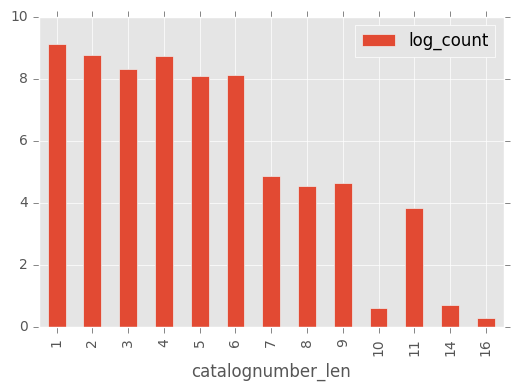

In [31]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

plt.figure();
(length_pd
 .sort_values(by="catalognumber_len")
 .plot(x="catalognumber_len", y="log_count", kind="bar")
)

plt.show()

In [22]:
length_pd[length_pd["catalognumber_len"] == 11]

,catalognumber_len,count
10,11,7017


In [ ]:
(joined
    .write
    .parquet("/outputs/idb-tokens-joined-{}.parquet".format(idb_df_version))
)